In [1]:
pip install phiflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.1/191.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.2/316.2 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for phiflow: filename=phiflow-3.2.0-py3-none-any.whl size=219836 sha256=b67bd390c2bd3439ae043113c8e06ed79f5d26464bb9b9f31f11142a43b5c6ea
  Stored in directory: /root/.cache/pip/wheels/87/3f/e0/3fc3444a47e1aa7a62a181ae5d5aa6a96f0dadddf015f4897c
  Created wheel for phiml: filename=phiml-1.10.2-py3-none-any.whl size=326853 sha256=fcdbe3a50902c62e3215d54eba6a67e2fe38cbbf3a14d6241a12271275c2e86e
  Stored in directory: /root/.cache/pip/wheels/e8/62/98/b21e4d419024451eae7fbee1d34b7ef6653b544dd87391680e
Successfully built phiflow phiml


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/phi/vis/_matplotlib/_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


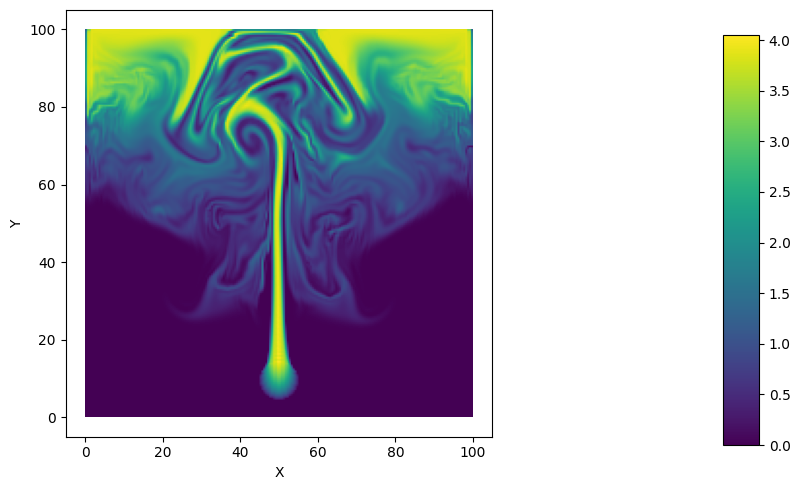

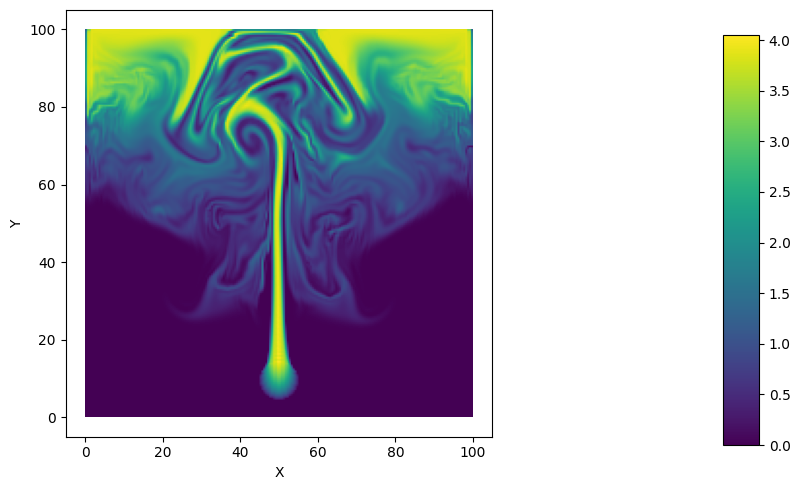

In [13]:
from phi.jax.flow import *
from tqdm.notebook import trange
domain = Box(x=100, y=100)
inflow = Sphere(x=50, y=9.5, radius=5)
inflow_rate = 0.2
@jit_compile
def step(v, s, p, dt):
    s = advect.mac_cormack(s, v, dt) + inflow_rate * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, (), Solve('CG', 1e-3, x0=p))
    return v, s, p

v0 = StaggeredGrid(0, 0, domain, x=64, y=64)
smoke0 = CenteredGrid(0, ZERO_GRADIENT, domain, x=200, y=200)
v_trj, s_trj, p_trj = iterate(step, batch(time=300), v0, smoke0, None, dt=.5, range=trange, substeps=3)
plot(s_trj.time[150])

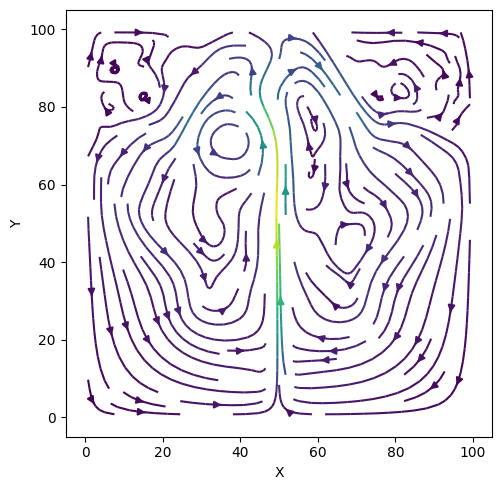

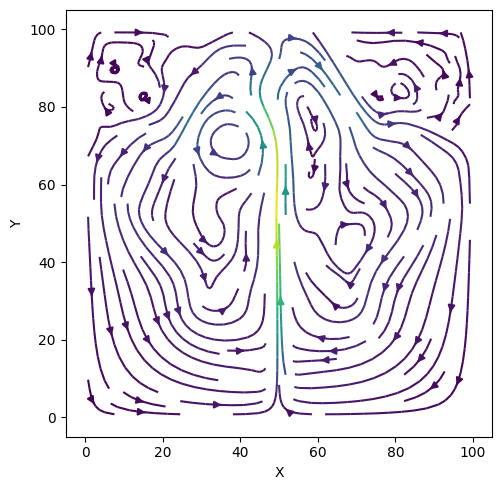

In [18]:
plot(v_trj.time[150])

In [29]:
import numpy as np
def identity_matrix(field: Field) -> Field:
    """
    Creates an identity matrix for the given field.

    Args:
        field (Field): The field for which to create an identity matrix.

    Returns:
        Field: An identity matrix field.
    """
    # Assuming the field is 2D, create an identity matrix with the same shape
    identity = np.eye(field.shape.sizes[0], field.shape.sizes[1])
    return field.with_values(math.tensor(identity, spatial(x=identity.shape[0],y=identity.shape[1])))
#def interpolate_to_centers(field):

def ProxLambdaF(density1:Field, density2:Field, coarse_velocity:Field, lambda_:float, alpha:float=1e-4, beta:float=1e-2, max_iters:int=50)->Field:
    """
    Velocity estimation operator prox_lambdaF in ADMM.
    section 5.1 in the paper.

    Args:
        density1 (Field): Density at time t.
        density2 (Field): Density at time t+1.
        coarse_velocity (Field): Initial velocity field (v).
        lambda_ (float): Proximal weight.
        alpha (float): Smoothness weight.
        beta (float): Kinetic energy weight.
        max_iters (int): Maximum iterations for solving the least squares problem.

    Returns:
        Field: Optimized velocity field (u).
    """
    # Precompute gradient of density
    grad_phi = density1.gradient(boundary=extrapolation.ZERO)  # Spatial gradient of the density ∇ϕ


    # Initialize fine-scale perturbation Δu_f
    delta_u_f = coarse_velocity * 0  # Same structure, zero values
    # Objective function to minimize
    # for _ in range(max_iters):
    # Total velocity: u = u_c + Δu_f
    total_velocity = coarse_velocity + delta_u_f
     # Photo-consistency term
    A_photo = grad_phi * grad_phi  # Outer product of density gradients A_photo=∇ϕ⋅∇ϕ
    density_diff = density2 - advect.semi_lagrangian(density1, total_velocity, dt=1.0)  # Transport mismatch the residual mismatch between the observed density at 𝑡+1 and the predicted density after advection by the velocity u
    b_photo = grad_phi * density_diff  # Linear term for mismatch, b_photo=∇ϕ⋅(ϕ2−ϕ1) captures the mismatch between observed and advected densities

    # Smoothness term
    A_smooth = alpha * field.laplace(total_velocity)  # Laplacian operator for smoothness
    b_smooth = alpha * field.laplace(coarse_velocity) # Contribution to b

    # Kinetic energy term (explicitly include its contribution)
    A_energy = beta * identity_matrix(total_velocity)  # Contribution to A
    b_energy = beta * coarse_velocity  # Contribution to b

    # Combine all terms into a single system
    # Define the linear operator for A=(I + λA FT),b=(V-λb FT)
    A = identity_matrix(total_velocity) + lambda_ * (A_photo + A_smooth + A_energy)  # Weighted sum of quadratic terms
    print(A.numpy())
    b= total_velocity- lambda_*(b_photo + b_smooth + b_energy)   # Weighted sum of linear terms


    A_centered = A.at_centers()

    b_centered = b.at_centers()
    @jit_compile_linear
    def A_operator(x):
        return A * x
        # Define the b_ft


    # Solve the system iteratively (e.g., with conjugate gradient)
    # Create a Solve object with initial guess and method
    solver = Solve('CG',x0=A_centered,preconditioner='ilu')  # Use conjugate gradient with velocity as initial guess
    #for using the solve_linear function, we need to convert the staggergrid into centeredgrid

    delta_u_f_centered = solve_linear(A_operator, b_centered, solve=solver,max_iters=max_iters)
    # Solve the system using a conjugate gradient solver
    # velocity_values, info = cg(A.values.numpy('x,y,vector'), b.values.numpy('x,y,vector'))
    # if info != 0:
    #     raise ValueError("Conjugate Gradient solver did not converge.")


    # Convert the optimized velocity back to a Field
    # optimized_velocity = velocity.with_values(velocity_values.reshape(velocity.shape.sizes))
    # delta_u_f = delta_u_f.with_values(delta_u_f_tensor)
    # convert the delta_u_f to staggeredgrid
    delta_u_f = StaggeredGrid(delta_u_f_centered, delta_u_f_centered.extrapolation, delta_u_f_centered.bounds, delta_u_f_centered.resolution)
    return coarse_velocity + delta_u_fe

plot(ProxLambdaF(s_trj.time[150], s_trj.time[151], v_trj.time[150], 1, 1e-4, 1e-2, 2))

[[[ 1.00926745e+00  1.00926769e+00]
  [ 6.38513768e-04  6.38715748e-04]
  [ 1.29649370e-05  1.33189815e-05]
  ...
  [ 2.83138371e+00  2.27448909e-04]
  [ 3.33881998e+00  9.73920047e-04]
  [ 4.02164698e+00  1.56204715e-01]]

 [[ 6.37982273e-04  6.38464699e-04]
  [ 1.00819266e+00  1.00819266e+00]
  [ 1.04105857e-03  1.04107696e-03]
  ...
  [ 3.93063854e-03  5.32798469e-04]
  [ 1.89116935e-03  6.25434768e-05]
  [ 2.43681556e-04  7.26501748e-04]]

 [[ 1.19185397e-05  1.29034797e-05]
  [ 1.04098581e-03  1.04098208e-03]
  [ 1.00753367e+00  1.00753367e+00]
  ...
  [ 6.85735047e-03  3.84138635e-04]
  [ 3.97755328e-04  1.96116371e-03]
  [ 6.92812819e-06  1.58216106e-03]]

 ...

 [[ 1.11109796e-06  1.33004274e-08]
  [-4.39159393e-08  4.63754759e-08]
  [-7.84143452e-08  8.39454870e-08]
  ...
  [ 1.01351964e+00  1.00788391e+00]
  [ 1.33408455e-03  3.06497002e-03]
  [ 3.81338905e-05  1.63795357e-03]]

 [[ 5.32445824e-07  3.04065608e-08]
  [-1.16297556e-07  8.97837609e-08]
  [-1.24750699e-07  1.5056

NotImplementedError: sparse triangular solves are not supported by jax. Try using a SciPy solver instead, such as 'scipy-CG' or 'scipy-biCG-stab'.